In [59]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, GlobalAveragePooling1D, UpSampling1D, BatchNormalization, Dropout, GlobalMaxPooling1D, ConvLSTM1D
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import random

In [2]:
timeframe = 40
stride = 1
num_features = 5

In [3]:
x_train = np.loadtxt('./data/X_train_transformed.csv')
x_train = x_train.reshape(x_train.shape[0], timeframe, num_features)
y_train = np.loadtxt('./data/y_train_transformed.csv').astype(int)
x_test = np.loadtxt('./data/X_test_transformed.csv')
x_test = x_test.reshape(x_test.shape[0], timeframe, num_features)
y_test = np.loadtxt('./data/y_test_transformed.csv').astype(int)

In [377]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((21560, 40, 5), (21560,), (5361, 40, 5), (5361,))

In [4]:
n_classes = 3

In [84]:
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(timeframe, num_features)),
    Conv1D(filters=64, kernel_size=2, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(n_classes, activation='softmax')
])

In [85]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [381]:
print(model.summary())

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_27 (Conv1D)              │ (None, 39, 64)         │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 38, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 19, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 1216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 64)             │        77,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,027 (347.76 KB)

 Trainable params: 89,027 (347.76 KB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [7]:
unique_labels = np.unique(y_train)
class_mapping = {label: i for i, label in enumerate(unique_labels)}
y_train_encoded = np.array([class_mapping[label] for label in y_train])
y_test_encoded = np.array([class_mapping[label] for label in y_test])

In [86]:
history = model.fit(x_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(x_test, y_test_encoded), callbacks=[early_stopping])

Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6792 - loss: 0.6663 - val_accuracy: 0.8830 - val_loss: 0.2670
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8874 - loss: 0.2566 - val_accuracy: 0.9077 - val_loss: 0.2016
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9030 - loss: 0.2081 - val_accuracy: 0.8922 - val_loss: 0.2152
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9096 - loss: 0.1872 - val_accuracy: 0.9108 - val_loss: 0.1875
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9232 - loss: 0.1615 - val_accuracy: 0.9052 - val_loss: 0.1947


In [88]:
loss, accuracy = model.evaluate(x_test, y_test_encoded)
print("Loss:", loss)
print("Accuracy:", accuracy)

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - accuracy: 0.8786 - loss: 0.2689
Loss: 0.2670307457447052
Accuracy: 0.8830441832542419


With 1 Conv+Pooling block and 1 Dense layer, accuracy ~= 0.59.

Comparable result when two Conv+Pooling blocks are used.

With one Conv+Conv+Pooling block and 2 Dense layers, accuracy went up to 0.965491533279419.

In [87]:
# selection of 1000 random samples from the test set
random.seed(42)  # Pour obtenir des résultats reproductibles
random_indices = random.sample(range(len(x_test)), 1000)
X_test_sample = x_test[random_indices]
y_test_sample = y_test_encoded[random_indices]

# evaluation of the model on the 1000 samples
y_pred_model = model.predict(X_test_sample)
# we take the class with the highest probability
y_pred_classes = np.argmax(y_pred_model, axis = 1)
accuracy_model = accuracy_score(y_test_sample, y_pred_classes)
precision_model = precision_score(y_test_sample, y_pred_classes, average='weighted')
recall_model = recall_score(y_test_sample, y_pred_classes, average='weighted')
f1_score_model = f1_score(y_test_sample, y_pred_classes, average='weighted')
conf_matrix_model = confusion_matrix(y_test_sample, y_pred_classes)
accuracy_model, precision_model, recall_model, f1_score_model, conf_matrix_model

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


(0.881,
 0.8827178654109228,
 0.881,
 0.8665223372372052,
 array([[ 11,   1,  58],
        [  0, 545,  42],
        [  5,  13, 325]]))

In [14]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return


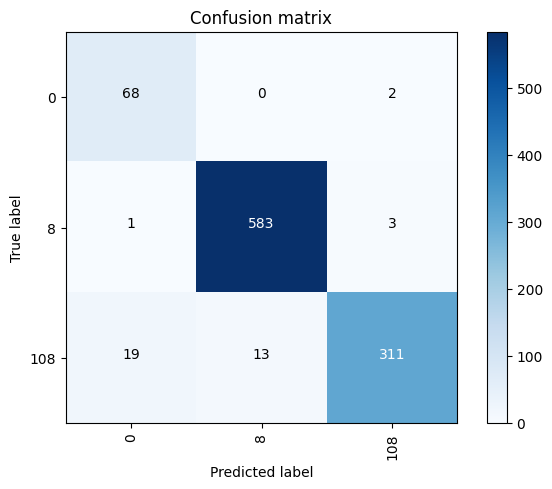

In [401]:
plot_confusion_matrix(conf_matrix_model, classes = [0, 8, 108])


In [78]:
model_2 = Sequential([
    Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(timeframe, num_features)),
    Conv1D(filters=128, kernel_size=2, activation='relu'),   
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax')
])
model_2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model_2.fit(x_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(x_test, y_test_encoded), callbacks=[early_stopping])

Epoch 1/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7119 - loss: 0.6162 - val_accuracy: 0.8976 - val_loss: 0.2238
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8981 - loss: 0.2216 - val_accuracy: 0.9151 - val_loss: 0.1808
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9174 - loss: 0.1909 - val_accuracy: 0.9161 - val_loss: 0.2003
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9307 - loss: 0.1647 - val_accuracy: 0.9336 - val_loss: 0.1561
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9366 - loss: 0.1624 - val_accuracy: 0.9412 - val_loss: 0.1378


In [81]:
loss, accuracy = model_2.evaluate(x_test, y_test_encoded)
print("Loss:", loss)
print("Accuracy:", accuracy)

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.9046 - loss: 0.2032
Loss: 0.20697394013404846
Accuracy: 0.9076665043830872


In [22]:
# selection of 1000 random samples from the test set
random.seed(42)  # Pour obtenir des résultats reproductibles
random_indices = random.sample(range(len(x_test)), 1000)
X_test_sample = x_test[random_indices]
y_test_sample = y_test_encoded[random_indices]

# evaluation of the model on the 1000 samples
y_pred_model = model_2.predict(X_test_sample)
# we take the class with the highest probability
y_pred_classes = np.argmax(y_pred_model, axis = 1)
accuracy_model = accuracy_score(y_test_sample, y_pred_classes)
precision_model = precision_score(y_test_sample, y_pred_classes, average='weighted')
recall_model = recall_score(y_test_sample, y_pred_classes, average='weighted')
f1_score_model = f1_score(y_test_sample, y_pred_classes, average='weighted')
conf_matrix_model = confusion_matrix(y_test_sample, y_pred_classes)
accuracy_model, precision_model, recall_model, f1_score_model, conf_matrix_model

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


/home/bina/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.587,
 0.34456899999999996,
 0.587,
 0.43423944549464394,
 array([[  0,  70,   0],
        [  0, 587,   0],
        [  0, 343,   0]]))

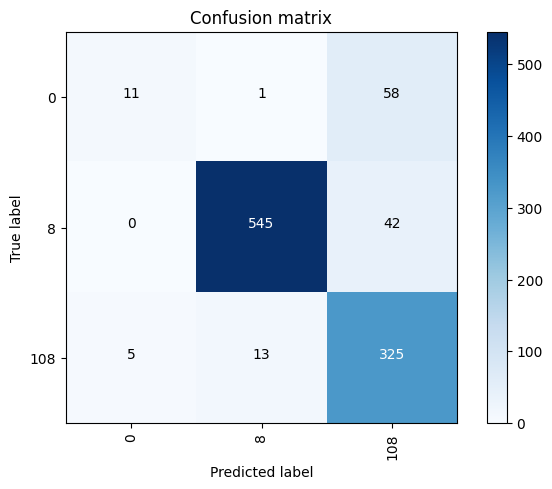

In [89]:
plot_confusion_matrix(conf_matrix_model, classes = [0, 8, 108])


In [82]:
model_3 = Sequential([
    Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(timeframe, num_features)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax')
])
model_3.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
history = model_3.fit(x_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(x_test, y_test_encoded), callbacks=[early_stopping])

Epoch 1/50


/home/bina/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


674/674 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7804 - loss: 0.4654 - val_accuracy: 0.9123 - val_loss: 0.1583
Epoch 2/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9195 - loss: 0.1614 - val_accuracy: 0.9368 - val_loss: 0.1281
Epoch 3/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9339 - loss: 0.1407 - val_accuracy: 0.9463 - val_loss: 0.1218
Epoch 4/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9453 - loss: 0.1236 - val_accuracy: 0.9455 - val_loss: 0.1191
Epoch 5/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9481 - loss: 0.1207 - val_accuracy: 0.9541 - val_loss: 0.1057
Epoch 6/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9585 - loss: 0.1017 - val_accuracy: 0.9569 - val_loss: 0.0980
Epoch 7/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9620 - loss: 0.0937 - val_accuracy: 0.9623 - val_loss: 0.0907
Epoch 8/50
674/674 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9683 - loss: 0.0835 - val_accuracy: 0.9612 - val_

In [83]:
loss, accuracy = model_3.evaluate(x_test, y_test_encoded)
print("Loss:", loss)
print("Accuracy:", accuracy)

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - accuracy: 0.9641 - loss: 0.0903
Loss: 0.08391840010881424
Accuracy: 0.9667972326278687
